In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import image_quality # image-quality
import image_quality.imquality as imquality
import image_quality.imquality.brisque as brisque
import PIL
from skimage import io, img_as_float
import time

video_path = './video.mp4'

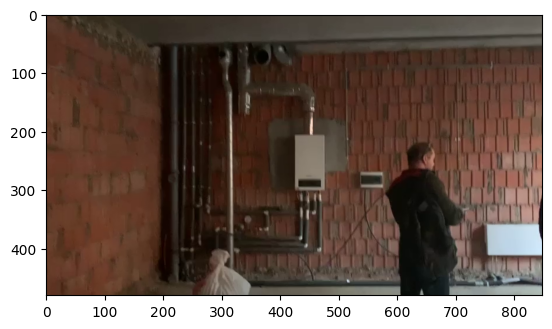

In [2]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
H, W, _ = frame.shape

i = 0
# while ret:
while i <= 0:
    ret, frame = cap.read()
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()
    i += 1

cap.release()
cv2.destroyAllWindows()

### light estimation

classification:  dark mean_val:  12.106494648435893


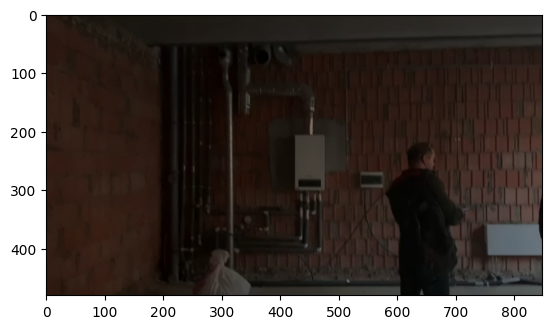

In [14]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
H, W, _ = frame.shape

i = 0
# while ret:
while i <= 0:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = frame // 2
#     frame = frame * 4
    frame = np.clip(frame, 0, 255)
    
    mean_val = np.mean(frame) * 100 / 255
    if mean_val < 15:
        classification = "dark" 
    elif mean_val > 40:
        classification = "too light"
    else:
        classification = "light"
    print("classification: ", classification, "mean_val: ", mean_val)
    
    plt.imshow(frame)
    plt.show()
    i += 1

cap.release()
cv2.destroyAllWindows()

### Brisque

brisque: 48.81517956794718
time 2.0207762718200684


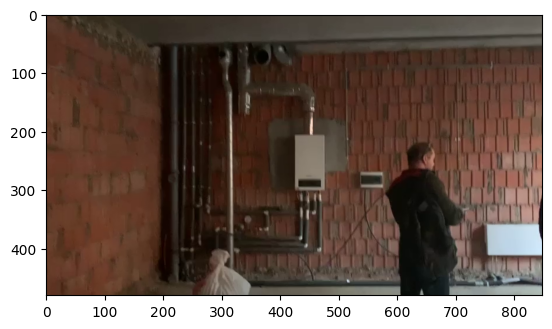

brisque: 49.79455725709303
time 2.6752026081085205


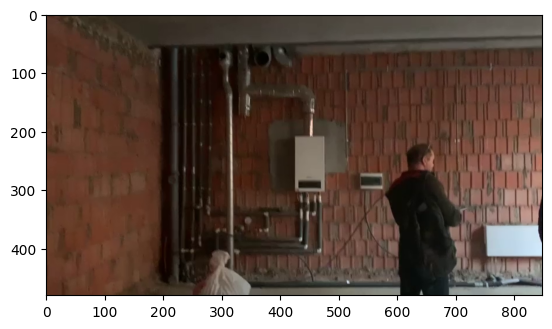

brisque: 52.03474755643694
time 2.5606398582458496


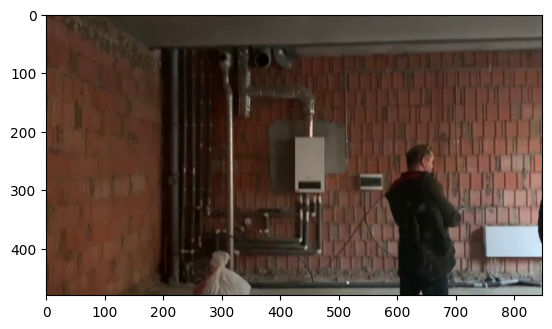

In [6]:
# сравнить с изображениями из исходных датасетами
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
H, W, _ = frame.shape

i = 0
while i <= 2:
    ret, frame = cap.read()
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    start = time.time()
    score = brisque.score(frame)
    finish = time.time()
    print("brisque:", score)
    print("time", finish - start)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()
    i += 1

cap.release()
cv2.destroyAllWindows()

Трешхолды

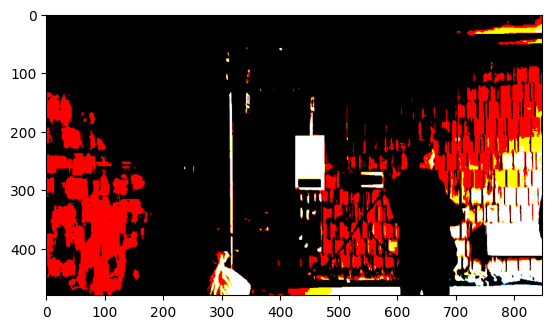

In [4]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
H, W, _ = frame.shape

i = 0
while i <= 0:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    _, frame = cv2.threshold(frame, 100, 255, cv2.THRESH_BINARY)
    plt.imshow(frame, cmap='gray')
    plt.show()
    i += 1

cap.release()
cv2.destroyAllWindows()

### дисперсия лапласиана

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Laplacian var:  746.5409167157736
time 0.010273456573486328


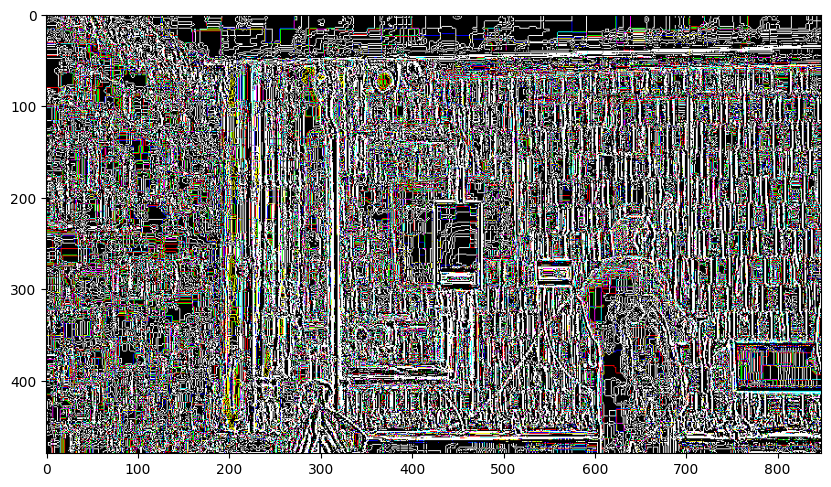

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Laplacian var:  643.3872575351336
time 0.013224601745605469


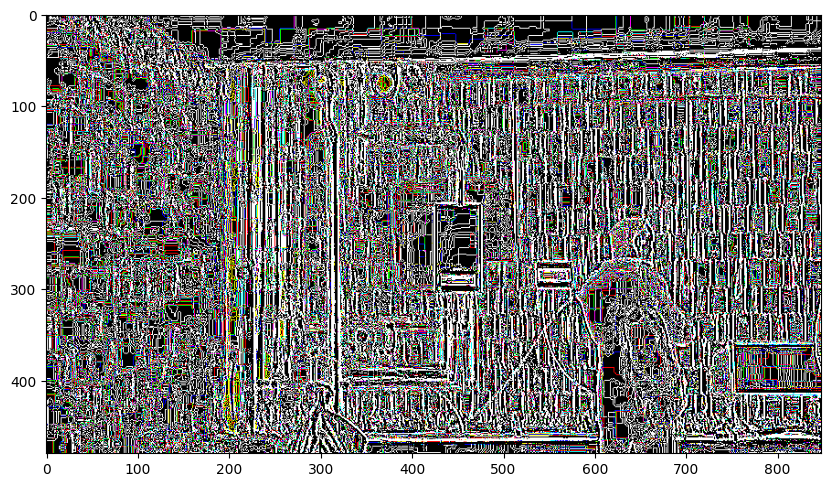

In [5]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
H, W, _ = frame.shape

kernel = np.array([[0, 1, 0],
                   [1, -4, 1],
                   [0, 1, 0]])

i = 0
while i <= 1:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     _, frame = cv2.threshold(frame, 100, 255, cv2.THRESH_BINARY)
#     frame = cv2.filter2D(frame, -1, kernel)
    start = time.time()
    frame = cv2.Laplacian(frame, cv2.CV_64F)
    print("Laplacian var: ", cv2.Laplacian(frame, cv2.CV_64F).var())
    finish = time.time()
    print("time", finish - start)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(frame, cmap='gray')
    plt.show()
    i += 1

cap.release()
cv2.destroyAllWindows()

### Преобразование Фурье

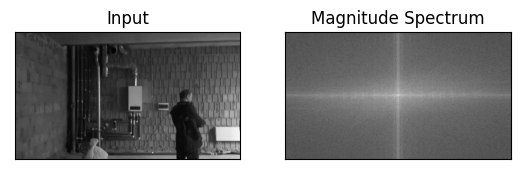

mean:  19.534906289760475
Not Blurry
time 0.16337370872497559


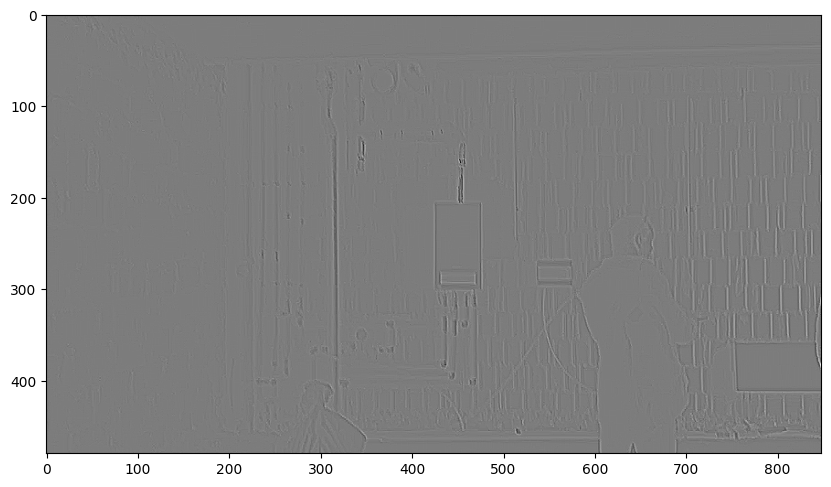

In [6]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
H, W, _ = frame.shape

def detect_blur_fft(image, size=60, thresh=10, vis=False):
    (h, w) = image.shape
    (cX, cY) = (int(w / 2.0), int(h / 2.0))

    fft = np.fft.fft2(image)
    fftShift = np.fft.fftshift(fft)
    if vis:

        magnitude = 20 * np.log(np.abs(fftShift))
        (fig, ax) = plt.subplots(1, 2, )
        ax[0].imshow(image, cmap="gray")
        ax[0].set_title("Input")
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        ax[1].imshow(magnitude, cmap="gray")
        ax[1].set_title("Magnitude Spectrum")
        ax[1].set_xticks([])
        ax[1].set_yticks([])

        plt.show()
    
    fftShift[cY - size:cY + size, cX - size:cX + size] = 0
    fftShift = np.fft.ifftshift(fftShift)
    recon = np.fft.ifft2(fftShift)
    
    magnitude = 20 * np.log(np.abs(recon))
    mean = np.mean(magnitude)

    return (mean, mean <= thresh)

i = 0
while i <= 0:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    start = time.time()
    
    (mean, blurry) = detect_blur_fft(frame, size=60, thresh=10, vis=True)
    finish = time.time()
    
    image = np.dstack([frame] * 3)
    
    frame = cv2.Laplacian(frame, cv2.CV_64F)
    print("mean: ", mean)
    if blurry:
        print("Blurry")
    else:
        print("Not Blurry")
    print("time", finish - start)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(frame, cmap='gray')
    plt.show()
    i += 1

cap.release()
cv2.destroyAllWindows()

Можно объединить две карты освещения

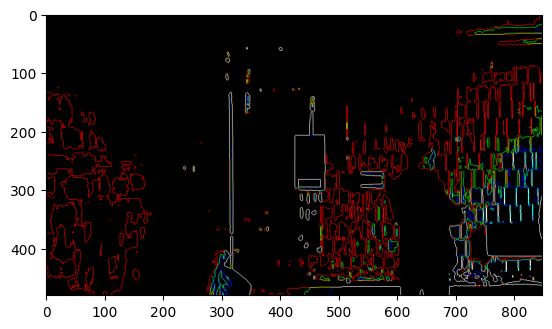

In [10]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
H, W, _ = frame.shape

kernel = np.array([[0, 1, 0],
                   [1, -4, 1],
                   [0, 1, 0]])

i = 0
while i <= 0:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    _, frame = cv2.threshold(frame, 100, 255, cv2.THRESH_BINARY)
    frame = cv2.filter2D(frame, -1, kernel)
    plt.imshow(frame, cmap='gray')
    plt.show()
    i += 1

cap.release()
cv2.destroyAllWindows()

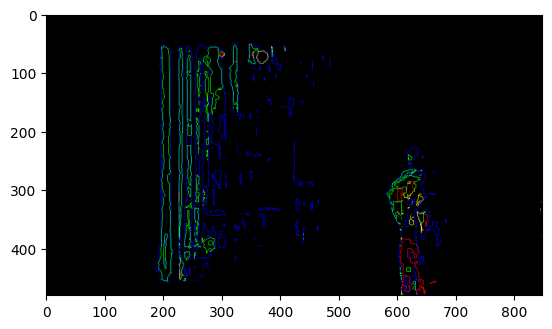

In [6]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
H, W, _ = frame.shape

kernel = np.array([[0, 1, 0],
                   [1, -4, 1],
                   [0, 1, 0]])

i = 0
# while ret:
while i <= 0:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    _, frame = cv2.threshold(frame, 10, 255, cv2.THRESH_BINARY)
    frame = cv2.filter2D(frame, -1, kernel)
    plt.imshow(frame, cmap='gray')
    plt.show()
    i += 1

cap.release()
cv2.destroyAllWindows()

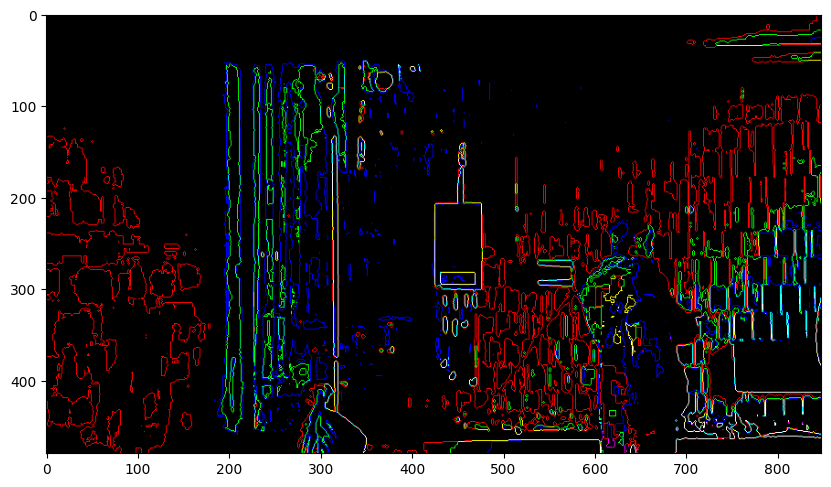

In [7]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
H, W, _ = frame.shape

kernel = np.array([[0, 1, 0],
                   [1, -4, 1],
                   [0, 1, 0]])

i = 0
while i <= 0:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    _, frame_1 = cv2.threshold(frame, 100, 255, cv2.THRESH_BINARY)
    frame_1 = cv2.filter2D(frame_1, -1, kernel)
    _, frame_2 = cv2.threshold(frame, 10, 255, cv2.THRESH_BINARY)
    frame_2 = cv2.filter2D(frame_2, -1, kernel)
    
    frame_1 = cv2.add(frame_1, frame_2)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(frame_1, cmap='gray')
    plt.show()
    i += 1

cap.release()
cv2.destroyAllWindows()

### Марцилиано

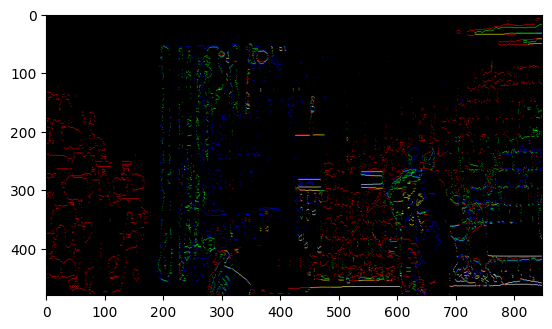

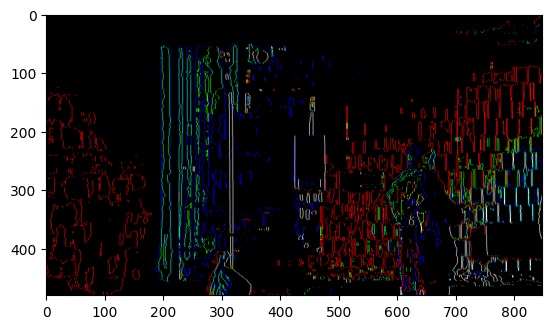

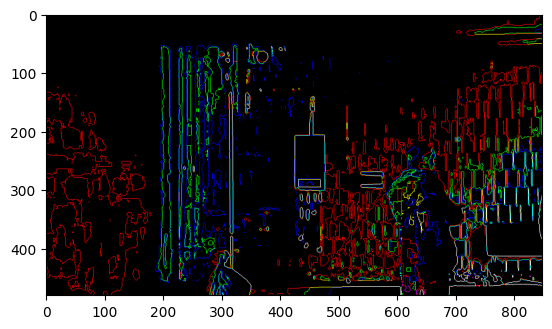

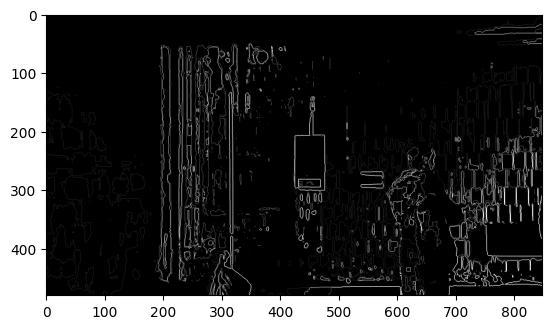

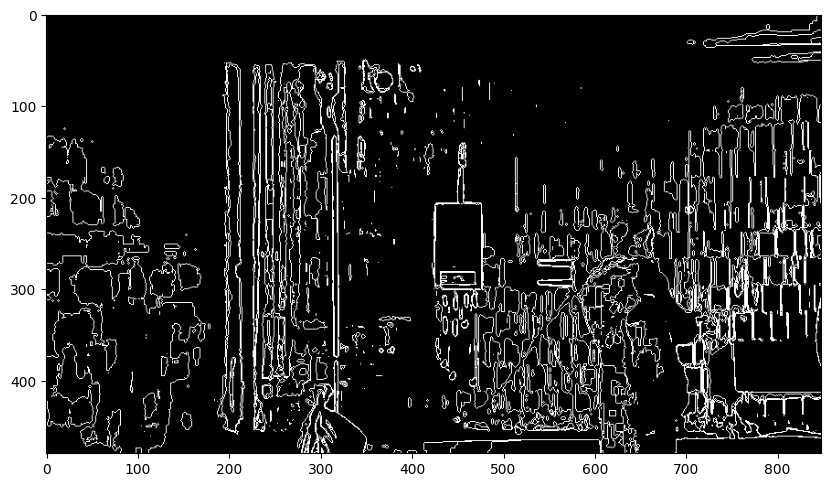

In [8]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
H, W, _ = frame.shape

kernel_v = np.array([[0, 1, 0],
                     [0, -4, 0],
                     [0, 1, 0]])

kernel_h = np.array([[0, 0, 0],
                     [1, -4, 1],
                     [0, 0, 0]])

cadr = 0
# while ret:
while cadr <= 0:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    _, frame_1 = cv2.threshold(frame, 100, 255, cv2.THRESH_BINARY)
    frame_1_v = cv2.filter2D(frame_1, -1, kernel_v)
    frame_1_h = cv2.filter2D(frame_1, -1, kernel_h)
    
    _, frame_2 = cv2.threshold(frame, 10, 255, cv2.THRESH_BINARY)
    frame_2_v = cv2.filter2D(frame_2, -1, kernel_v)
    frame_2_h = cv2.filter2D(frame_2, -1, kernel_h)
    
    frame_3_v = cv2.add(frame_1_v, frame_2_v)
    frame_3_h = cv2.add(frame_1_h, frame_2_h)
    
    frame_3 = cv2.add(frame_3_v, frame_3_h)

    
    plt.imshow(frame_3_v, cmap='gray')
    plt.show()
    
    plt.imshow(frame_3_h, cmap='gray')
    plt.show()
    
    plt.imshow(frame_3, cmap='gray')
    plt.show()
    
    plt.imshow(cv2.cvtColor(frame_3, cv2.COLOR_BGR2GRAY), cmap='gray')
    plt.show()
    
    frame_3 = cv2.cvtColor(frame_3, cv2.COLOR_BGR2GRAY)
    frame_4 = np.where(frame_3 > 0, 255, 0)
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(frame_4, cmap="gray")
    plt.show()
    
    cadr += 1

cap.release()
cv2.destroyAllWindows()

width_horisontal 15660
n_edges 13516
avg_width_horisontal 1.1586268126664694
width_vertical 33053
n_edges 29539
avg_width_vertical 1.1189613730999695
time 1.8541738986968994


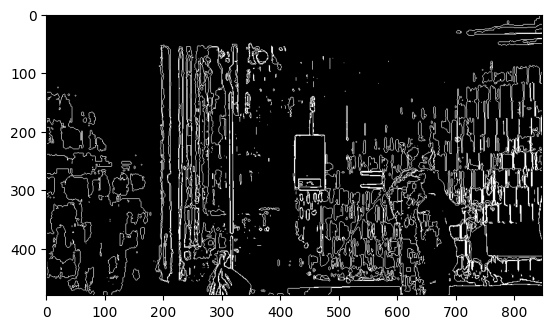

In [8]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
H, W, _ = frame.shape

kernel_v = np.array([[0, 1, 0],
                     [0, -4, 0],
                     [0, 1, 0]])

kernel_h = np.array([[0, 0, 0],
                     [1, -4, 1],
                     [0, 0, 0]])

cadr = 0
# while ret:
while cadr <= 0:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    start = time.time()
    
    _, frame_1 = cv2.threshold(frame, 100, 255, cv2.THRESH_BINARY)
    frame_1_v = cv2.filter2D(frame_1, -1, kernel_v)
    frame_1_h = cv2.filter2D(frame_1, -1, kernel_h)
    
    _, frame_2 = cv2.threshold(frame, 10, 255, cv2.THRESH_BINARY)
    frame_2_v = cv2.filter2D(frame_2, -1, kernel_v)
    frame_2_h = cv2.filter2D(frame_2, -1, kernel_h)
    
    frame_3_v = cv2.add(frame_1_v, frame_2_v)
    frame_3_h = cv2.add(frame_1_h, frame_2_h)
    
    frame_3_v = cv2.cvtColor(frame_3_v, cv2.COLOR_BGR2GRAY)
    frame_3_h = cv2.cvtColor(frame_3_h, cv2.COLOR_BGR2GRAY)
    
    frame_3 = cv2.add(frame_3_v, frame_3_h)
    
    pairs_v = {}
    n_edges_v, n_edges_h = 0, 0
    average_width_v, average_width_h = 0, 0
    
    if len(frame_3_v) > 0:
        for i in range(len(frame_3_v)):
            for j in range(len(frame_3_v[0])):
                length_v = 0
                if (frame_3_v[i][j] > 0) and (i, j) not in pairs_v:
                    length_v += 1
                    pairs_v[(i, j)] = length_v
                    n_edges_v += 1
                    z = i + 1
                    while z < len(frame_3_v) and (frame_3_v[z][j] > 0) and (z, j) not in pairs_v:
                        pairs_v[(z, j)] = length_v
                        length_v += 1
                        z += 1
                    average_width_v += length_v
    
    pairs_h = {}
    if len(frame_3_h) > 0:
        for i in range(len(frame_3_h)):
            for j in range(len(frame_3_h[0])):
                length_h = 0
                if (frame_3_h[i][j] > 0) and (i, j) not in pairs_h:
                    length_h += 1
                    pairs_h[(i, j)] = length_h
                    n_edges_h += 1
                    z = j + 1
                    while z < len(frame_3_h) and (frame_3_h[i][z] > 0) and (i, z) not in pairs_h:
                        pairs_h[(i, z)] = length_h
                        length_h += 1
                        z += 1
                    average_width_h += length_h
                    
    finish = time.time()
                            
    if n_edges_v > 0:
        print("width_horisontal", average_width_v)
        print("n_edges", n_edges_v)
        average_width_v /= n_edges_v
        print("avg_width_horisontal", average_width_v)
        
    if n_edges_h > 0:
        print("width_vertical", average_width_h)
        print("n_edges", n_edges_h)
        average_width_h /= n_edges_h
        print("avg_width_vertical", average_width_h)
        
    print("time", finish - start)
    
    frame_4 = np.where(frame_3 > 0, 255, 0)
    
    plt.imshow(frame_4, cmap="gray")
    plt.show()
    
    cadr += 1

cap.release()
cv2.destroyAllWindows()

avg_width_horisontal 1.1586268126664694
avg_width_vertical 1.2936088607099527
time 2.0271167755126953


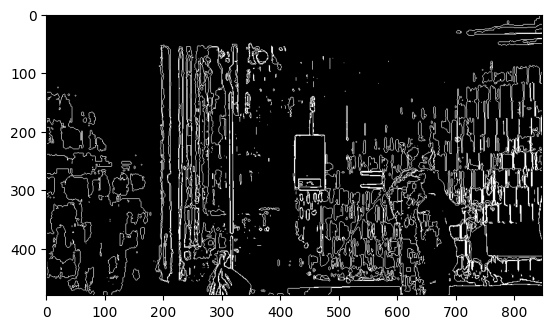

avg_width_horisontal 1.1634694334552511
avg_width_vertical 1.2849120617712435
time 2.3377344608306885


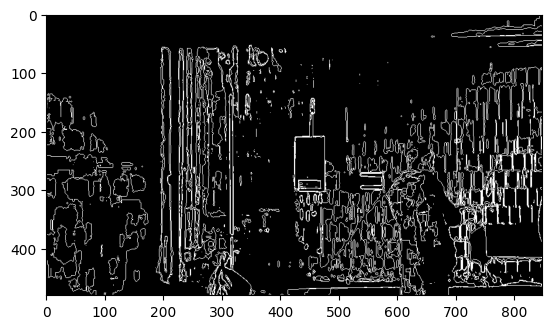

In [11]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
H, W, _ = frame.shape

kernel_v = np.array([[0, 1, 0],
                     [0, -4, 0],
                     [0, 1, 0]])

kernel_h = np.array([[0, 0, 0],
                     [1, -4, 1],
                     [0, 0, 0]])

cadr = 0
while cadr <= 1:
    ret, frame = cap.read()
    start = time.time()
    
    _, frame_1 = cv2.threshold(frame, 100, 255, cv2.THRESH_BINARY)
    frame_1_v = cv2.filter2D(frame_1, -1, kernel_v)
    frame_1_h = cv2.filter2D(frame_1, -1, kernel_h)
    
    _, frame_2 = cv2.threshold(frame, 10, 255, cv2.THRESH_BINARY)
    frame_2_v = cv2.filter2D(frame_2, -1, kernel_v)
    frame_2_h = cv2.filter2D(frame_2, -1, kernel_h)
    
    frame_3_v = cv2.add(frame_1_v, frame_2_v)
    frame_3_h = cv2.add(frame_1_h, frame_2_h)
    
    frame_3_v = cv2.cvtColor(frame_3_v, cv2.COLOR_BGR2GRAY)
    frame_3_h = cv2.cvtColor(frame_3_h, cv2.COLOR_BGR2GRAY)
    
    frame_3 = cv2.add(frame_3_v, frame_3_h)
    
    pairs_v, pairs_h = {}, {}
    n_edges_v, n_edges_h = 0, 0
    average_width_v, average_width_h = 0, 0
    
    if len(frame_3) > 0:
        for i in range(len(frame_3)):
            for j in range(len(frame_3[0])):
                length_v, length_h = 0, 0
                for k in [0, 1]:
                    if k == 0:
                        if (frame_3_v[i][j] > 0) and (i, j) not in pairs_v:
                            length_v += 1
                            pairs_v[(i, j)] = length_v
                            n_edges_v += 1
                            z = i + 1
                            while z < len(frame_3_v) and (frame_3_v[z][j] > 0) and (z, j) not in pairs_v:
                                pairs_v[(z, j)] = length_v
                                length_v += 1
                                z += 1
                            average_width_v += length_v
                    else:
                        if (frame_3_h[i][j] > 0) and (i, j) not in pairs_h:
                            length_h += 1
                            pairs_h[(i, j)] = length_h
                            n_edges_h += 1
                            z = j + 1
                            while z < len(frame_3_h[0]) and (frame_3_h[i][z] > 0) and (i, z) not in pairs_h:
                                pairs_h[(i, z)] = length_h
                                length_h += 1
                                z += 1
                            average_width_h += length_h
                            
    finish = time.time()
                            
    if n_edges_v > 0:
        average_width_v /= n_edges_v
        print("avg_width_horisontal", average_width_v)
        
    if n_edges_h > 0:
        average_width_h /= n_edges_h
        print("avg_width_vertical", average_width_h)
        
    print("time", finish - start)
    
    frame_4 = np.where(frame_3 > 0, 255, 0)
    
    plt.imshow(frame_4, cmap="gray")
    plt.show()
    
    cadr += 1

cap.release()
cv2.destroyAllWindows()